In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

df = pd.read_csv(os.path.join("..", "data", "NFLX.csv"))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-08,143.570007,145.070007,142.559998,144.740005,144.740005,6887100
1,2017-02-09,144.979996,145.089996,143.580002,144.139999,144.139999,4555100
2,2017-02-10,144.679993,145.300003,143.970001,144.820007,144.820007,6171900
3,2017-02-13,145.190002,145.949997,143.050003,143.199997,143.199997,4790400
4,2017-02-14,143.199997,144.110001,140.050003,140.820007,140.820007,8367800


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [3]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df_sort = df.sort_values(by='Date', ascending=True)

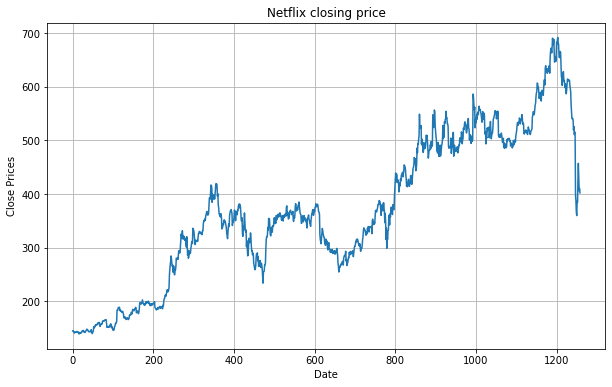

In [6]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_sort['Close'])
plt.title('Netflix closing price')
plt.show()

In [7]:
dfc = df['Close']

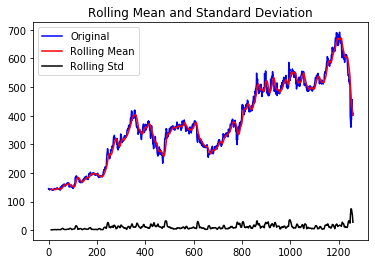

Results of dickey fuller test
Test Statistics                  -1.797600
p-value                           0.381654
No. of lags used                 23.000000
Number of observations used    1235.000000
critical value (1%)              -3.435656
critical value (5%)              -2.863883
critical value (10%)             -2.568018
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(dfc)

<Figure size 432x288 with 0 Axes>

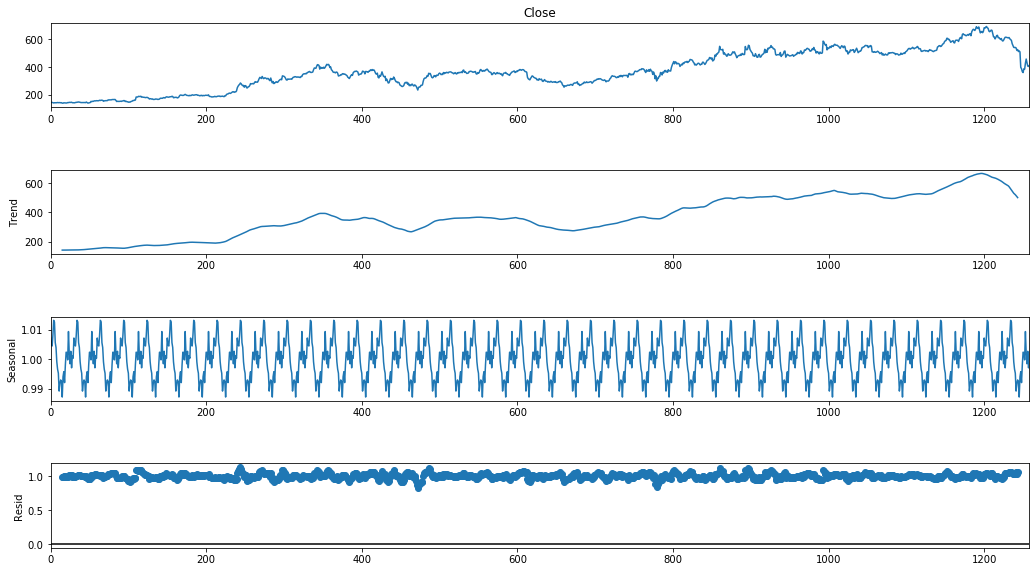

In [9]:
result = seasonal_decompose(dfc, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

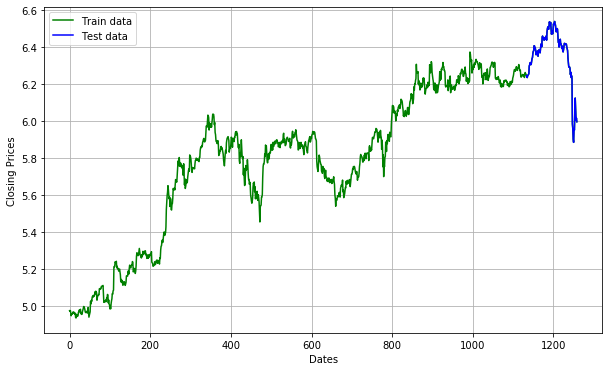

In [11]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5150.032, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5155.340, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5154.705, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5149.618, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5155.455, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5153.833, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5153.892, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5155.013, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5151.896, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5154.864, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.369 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1130
Model:               SARIMAX(2, 1, 0)   Log Likeliho

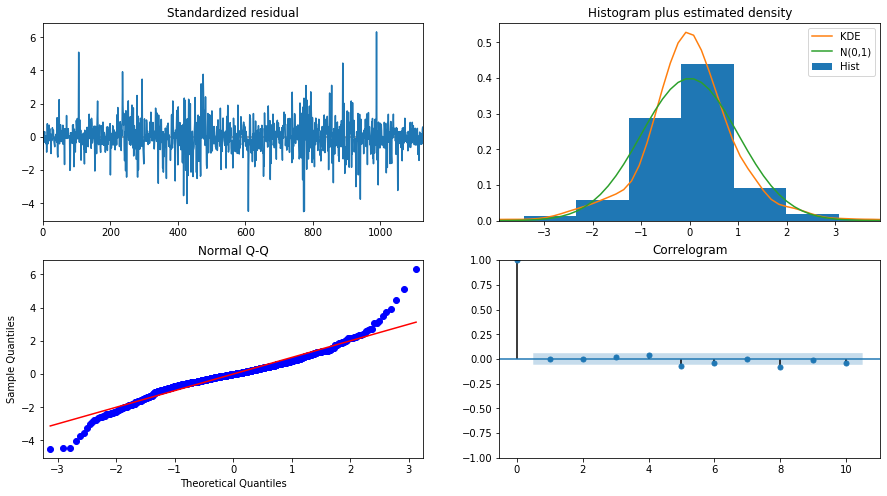

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [13]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1129
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2580.670
Method:                       css-mle   S.D. of innovations              0.025
Date:                Thu, 10 Feb 2022   AIC                          -5155.341
Time:                        01:37:42   BIC                          -5140.253
Sample:                             1   HQIC                         -5149.640
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.687      0.092      -0.000       0.002
ar.L1.D.Close    -0.0803      0.030     -2.708      0.007      -0.138      -0.022
                                    Root

In [14]:
# Forecast
fc, se, conf = fitted.forecast(126, alpha=0.05)  # 97% conf

In [15]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

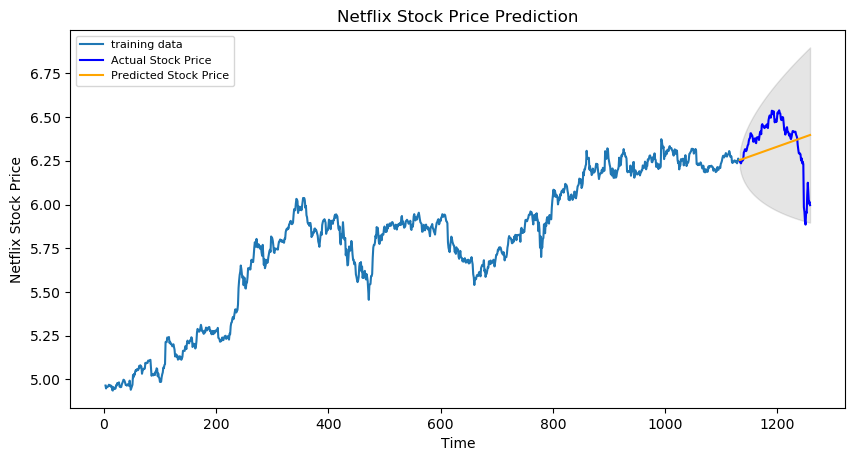

In [16]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.028078338164283727
MAE: 0.13113384663574387
RMSE: 0.16756592184654887
MAPE: 0.020831353269518512
